# Weather Emotion Feed-forward Neural Network

Learn the projection of weather parameters into the 2D Valence-Arousal emotional space.

### Author

Takeshi Matsumura

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import tensorflow as tf

from model.WeatherVAE import WeatherVAE
from model.WeatherEmotionFNN import WeatherEmotionFNN, load_weather_words_emotion_data
from common import common

In [2]:
common.init_notebook()

In [3]:
my_2_palette = [sns.color_palette("rainbow", 5)[0], sns.color_palette("rainbow", 5)[4]]
my_5_palette = sns.color_palette("rainbow", 5)

In [4]:
# The dimension of the latent emotional space. Start with 2 (Valence & Arousal).
latent_dim = 2

# The units of the VAE Dense Layers. Obtained by Optuna.
units = [284, 184, 160] # From weather-emotion-fnn-4 (trial 37, the best among the 3-layer trials)

# Drop out rate
init_dropout_rate = 0.2
dropout_rate = 0.2

## Open the Weather words - Emotion relation data

In [5]:
weather_words_emotion_df = load_weather_words_emotion_data()
weather_words_emotion_df

,weather_word,Valence_mean,Valence_SD,Arousal_mean,Arousal_SD,Dominance_mean,Dominance_SD,Surprise_mean,Surprise_SD,Cluster
0,Airy,7.33,1.69,4.04,2.67,6.44,1.84,3.76,1.98,1.0
1,Arctic,3.32,2.34,5.42,2.35,3.14,2.15,6.27,2.15,2.0
2,Arid,4.17,1.91,3.70,1.81,4.92,1.93,4.15,2.06,3.0
3,Bad,2.74,1.76,5.53,2.05,3.14,1.77,5.14,2.28,2.0
4,Balmy,6.05,2.07,4.50,2.03,5.73,2.12,4.28,1.91,1.0
...,...,...,...,...,...,...,...,...,...,...
136,Winter,5.53,2.38,4.52,2.10,5.02,1.92,3.64,1.91,3.0
137,Winter Storm,4.41,2.28,6.24,1.86,3.89,2.11,6.70,2.11,2.0
138,Winter Storm Warning,4.11,2.34,6.18,2.28,3.36,1.83,6.78,2.29,2.0
139,Winter Storm Watch,4.46,2.33,5.56,2.03,3.97,1.93,6.14,1.90,2.0


In [6]:
# Ignore the Dominance and Surprise as they have high correlation with the Valence And Arousal.
# Also, ignore the standard deviation.

weather_words_emotion_df.drop(columns=["Valence_SD", "Arousal_SD", "Dominance_mean", "Dominance_SD", "Surprise_mean", "Surprise_SD", "Cluster"], inplace=True)

# Rename Valence_mean and Arousal_mean to Valence and Arousal respectively.
weather_words_emotion_df.columns = ["weather_word", "Valence", "Arousal"]

weather_words_emotion_df

,weather_word,Valence,Arousal
0,Airy,7.33,4.04
1,Arctic,3.32,5.42
2,Arid,4.17,3.70
3,Bad,2.74,5.53
4,Balmy,6.05,4.50
...,...,...,...
136,Winter,5.53,4.52
137,Winter Storm,4.41,6.24
138,Winter Storm Warning,4.11,6.18
139,Winter Storm Watch,4.46,5.56


In [7]:
# Check the statistics
weather_words_emotion_df.describe()

,Valence,Arousal
count,141.000000,141.000000
mean,4.365887,4.740142
std,1.648140,1.104460
min,2.210000,2.590000
25%,3.070000,3.870000
50%,3.890000,4.670000
75%,4.920000,5.620000
max,8.360000,7.110000


In [8]:
# Filter the data frame by the words used for annotating the weather data.
used_weather_words = [
  'Hot', 'Warm', 'Comfortable', 'Cool', 'Cold', 'Freezing',
  'Humid', 'Dry',
  'Rainy', 'Drizzle',
  'Breezy', 'Windy', 'Gusty', 'Blustery',
  'Clear', 'Partly Cloudy', 'Cloudy', 'Overcast'
]

# Reducing the number of used weather words makes the loss value reported by the training worse than the loss reported by Optuna 
# where the words are not reduced. It does not matter because the R2 value will be the same regardless the weather words are reduced or not.
weather_words_emotion_df = weather_words_emotion_df[weather_words_emotion_df['weather_word'].isin(used_weather_words)]


In [9]:
# Standardise the Valence and Arousal
# They are in the [1, 9] range. See the original paper.
mm_scaler = MinMaxScaler()

def standardise_va(df):
  # return (df - 1) / (9 - 1)
  return mm_scaler.fit_transform(df)

weather_words_emotion_df[['Valence', 'Arousal']] = standardise_va(weather_words_emotion_df[['Valence', 'Arousal']])
weather_words_emotion_df.describe()

/var/folders/hk/cnl8wdkj2jx634qcdjdtz1dc0000gn/T/ipykernel_8637/3640295772.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_words_emotion_df[['Valence', 'Arousal']] = standardise_va(weather_words_emotion_df[['Valence', 'Arousal']])


,Valence,Arousal
count,18.000000,18.000000
mean,0.452726,0.473545
std,0.288757,0.306694
min,0.000000,0.000000
25%,0.296584,0.173160
50%,0.366460,0.491342
75%,0.613354,0.719697
max,1.000000,1.000000


In [10]:
weather_words_emotion_df

,weather_word,Valence,Arousal
7,Blustery,0.248447,1.000000
9,Breezy,0.546584,0.740260
15,Clear,0.983437,0.463203
16,Cloudy,0.347826,0.025974
17,Cold,0.291925,0.519481
18,Comfortable,1.000000,0.406926
19,Cool,0.730849,0.623377
28,Drizzle,0.310559,0.147186
31,Dry,0.378882,0.238095
45,Freezing,0.082816,0.614719


<Axes: xlabel='Valence', ylabel='Arousal'>

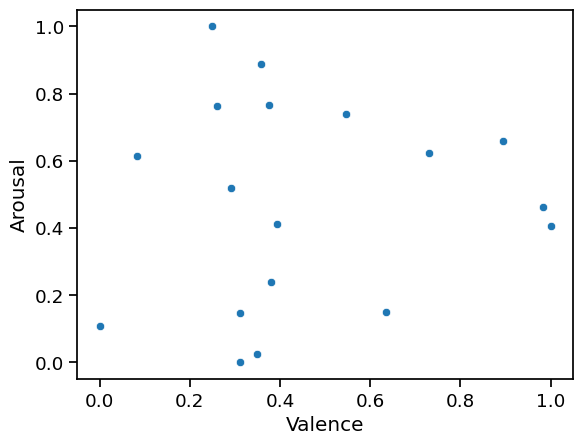

In [11]:
# Visualise the Valence and Arousal distribution in the 2D space.
sns.scatterplot(weather_words_emotion_df, x='Valence', y='Arousal')

## Import weather data for training

In [12]:
# The x,y index of the grid to use the data from.
focus_grid = (6, 3)


In [13]:
# Load the trained Weather VAE model.
weather_vae = WeatherVAE()
weather_vae.load_model()
encoder_loaded = weather_vae.encoder

In [14]:
df = weather_vae.load_nwp_data()
df = weather_vae.feature_engineering(df)
df_std = weather_vae.scale_data(df)
used_columns = df_std.columns

In [15]:
df = df.reset_index(drop=True)
df

,date_time,y,x,cloud_amount_of_high_cloud,cloud_amount_of_low_cloud,cloud_amount_of_medium_cloud,cloud_amount_of_total_cloud,fog_fraction_at_screen_level,pressure_at_surface,relative_humidity_at_screen_level,temperature_at_screen_level,visibility_at_screen_level,rainfall_accumulation-PT01H,snowfall_accumulation-PT01H,wx,wy
0,2023010100,3,6,1.000000,1.000000,1.000000,1.000000,0.0,98819.3750,0.929688,276.593750,4079.0,0.001233,0.0,2.038905,4.633764
1,2023010101,3,6,1.000000,1.000000,1.000000,1.000000,0.0,98782.3750,0.931641,276.781250,2585.0,0.001595,0.0,0.621039,3.761578
2,2023010102,3,6,1.000000,1.000000,1.000000,1.000000,0.0,98705.3125,0.950195,276.992188,2890.0,0.001896,0.0,1.676363,3.973344
3,2023010103,3,6,1.000000,1.000000,1.000000,1.000000,0.0,98685.3125,0.958984,277.312500,2698.0,0.000605,0.0,1.833967,2.607052
4,2023010104,3,6,1.000000,1.000000,1.000000,1.000000,0.0,98717.6250,0.957031,277.296875,6100.0,0.000884,0.0,0.509088,1.739536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8743,2023123119,3,6,0.000000,0.273438,0.140625,0.515625,0.0,97392.3750,0.900391,278.484375,6784.0,0.000000,0.0,1.491712,0.464974
8744,2023123120,3,6,0.000000,0.906250,0.359375,0.937500,0.0,97495.0625,0.887695,278.234375,6996.0,0.000000,0.0,0.414626,-2.655323
8745,2023123121,3,6,0.000000,0.726562,0.109375,0.796875,0.0,97543.6875,0.887695,278.140625,8191.0,0.000000,0.0,1.096773,-2.035865
8746,2023123122,3,6,0.000000,0.828125,0.046875,0.937500,0.0,97656.3125,0.890625,277.718750,7241.0,0.000000,0.0,0.266794,-2.297058


## Generate the corresponding latent weather vectors

In [16]:
std_custom_set, label_set = weather_vae.prepare_dataset(df, df_std)
time_set = weather_vae.create_time_input(label_set)
latent_weather_vectors = encoder_loaded.predict([std_custom_set, time_set])

274/274 [==============================] - 0s 403us/step


In [17]:
latent_weather_vectors.shape

(8748, 8)

## Annotate weather data by weather words

Annotate subsets of NWP weather data by the weather words. Not all the weather words can be used. Not all the weather data can be annotated.
This annotation really needs advice from someone living in Edinburgh.

In [18]:
df.describe()

,date_time,y,x,cloud_amount_of_high_cloud,cloud_amount_of_low_cloud,cloud_amount_of_medium_cloud,cloud_amount_of_total_cloud,fog_fraction_at_screen_level,pressure_at_surface,relative_humidity_at_screen_level,temperature_at_screen_level,visibility_at_screen_level,rainfall_accumulation-PT01H,snowfall_accumulation-PT01H,wx,wy
count,8.748000e+03,8748.0,8748.0,8748.000000,8748.000000,8748.000000,8748.000000,8748.000000,8748.000000,8748.000000,8748.000000,8748.000000,8748.000000,8.748000e+03,8748.000000,8748.000000
mean,2.023067e+09,3.0,6.0,0.377328,0.553754,0.426848,0.760292,0.003494,100203.046353,0.782868,283.280055,21848.224966,0.000101,8.710400e-07,-0.786200,-1.222751
std,3.449347e+04,0.0,0.0,0.408408,0.389760,0.413490,0.339449,0.040812,1359.725997,0.122855,5.139180,10874.726253,0.000438,2.657224e-05,2.378171,3.656988
min,2.023010e+09,3.0,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,96089.062500,0.270508,268.562500,39.000000,0.000000,0.000000e+00,-11.180685,-12.932991
25%,2.023040e+09,3.0,6.0,0.000000,0.140625,0.000000,0.601562,0.000000,99347.562500,0.712646,279.593750,14208.000000,0.000000,0.000000e+00,-2.065147,-3.827813
50%,2.023070e+09,3.0,6.0,0.156250,0.625000,0.320312,0.960938,0.000000,100337.312500,0.804199,283.125000,21817.000000,0.000000,0.000000e+00,-0.624773,-1.444110
75%,2.023100e+09,3.0,6.0,0.828125,0.968750,0.898438,1.000000,0.000000,101177.187500,0.874023,287.148438,29270.500000,0.000000,0.000000e+00,0.710298,1.738227
max,2.023123e+09,3.0,6.0,1.000000,1.000000,1.000000,1.000000,1.000000,103590.500000,1.009766,298.703125,76930.000000,0.007903,1.399994e-03,6.652169,10.706945


In [19]:
df.columns

Index(['date_time', 'y', 'x', 'cloud_amount_of_high_cloud',
       'cloud_amount_of_low_cloud', 'cloud_amount_of_medium_cloud',
       'cloud_amount_of_total_cloud', 'fog_fraction_at_screen_level',
       'pressure_at_surface', 'relative_humidity_at_screen_level',
       'temperature_at_screen_level', 'visibility_at_screen_level',
       'rainfall_accumulation-PT01H', 'snowfall_accumulation-PT01H', 'wx',
       'wy'],
      dtype='object')

In [20]:
weather_emotion_fnn = WeatherEmotionFNN()
word_indices = weather_emotion_fnn.create_word_indices(df, 300)

In [21]:
latent_weather_vectors

array([[-0.6170584 , -0.7124589 ,  0.25280368, ..., -0.11491507,
        -0.29057136, -0.20188764],
       [-0.53469986, -0.721061  ,  0.21745802, ...,  0.06670482,
        -0.40853643, -0.20544726],
       [-0.80329645, -0.60930496,  0.13425478, ..., -0.2092402 ,
        -0.3704521 , -0.10066906],
       ...,
       [ 0.10837813, -0.00971425, -0.24694028, ..., -0.30718502,
         0.03953442, -0.9024674 ],
       [ 0.08514851,  0.1792434 , -0.04539108, ..., -0.2178354 ,
        -0.18342683, -0.6187765 ],
       [-0.19635281, -0.01108643, -0.03376828, ..., -0.07472417,
        -0.1448263 , -0.63604623]], dtype=float32)

In [22]:
# Create color palette for the scatter plots

unique_labels = sorted(word_indices.keys())
hue_order = unique_labels
# tab10 creates a color palette to repeating 10 colors.
palette = sns.color_palette('tab10', len(set(unique_labels)))
palette = dict(zip(unique_labels, palette))
markers = sum([[m] * 10 for m in ['o', 'D']], [])[:len(unique_labels)]
markers = dict(zip(unique_labels, markers))

## Create the training data from the weather features (12D) and the annotated weather data

In [23]:
weather_words_emotion_df["weather_word"].to_list()

['Blustery',
 'Breezy',
 'Clear',
 'Cloudy',
 'Cold',
 'Comfortable',
 'Cool',
 'Drizzle',
 'Dry',
 'Freezing',
 'Gusty',
 'Hot',
 'Humid',
 'Overcast',
 'Partly Cloudy',
 'Rainy',
 'Warm',
 'Windy']

In [24]:
weather_dataset_df,label_set_df = weather_emotion_fnn.get_annotated_weather_data(weather_words_emotion_df, word_indices, latent_weather_vectors)

In [25]:
def va_scatter(df):
  """
  Draw a scatter plot of valence-arousal space.
  """
  fig, ax = plt.subplots(figsize=(6, 5))
  sns.scatterplot(df, x='Valence', y='Arousal', hue='weather_word', style='weather_word', palette=palette, hue_order=hue_order, markers=markers, ax=ax)
  ax.legend(title="Label", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

def va_scatter2(df1, df2, titles):
  """
  Draw two scatter plots of valence-arousal space.
  """
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  sns.scatterplot(df1, x='Valence', y='Arousal', hue='weather_word', style='weather_word', palette=palette, hue_order=hue_order, markers=markers, ax=axes[0])
  sns.scatterplot(df2, x='Valence', y='Arousal', hue='weather_word', style='weather_word', palette=palette, hue_order=hue_order, markers=markers, ax=axes[1])
  # ax.legend(title="Label", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
  axes[0].set_title(titles[0])
  axes[1].set_title(titles[1])
  handles, labels = axes[1].get_legend_handles_labels()
  axes[0].legend_.remove()
  axes[1].legend_.remove()
  fig.legend(handles, labels, title='Label', loc='center left', bbox_to_anchor=(0.925, 0.5))



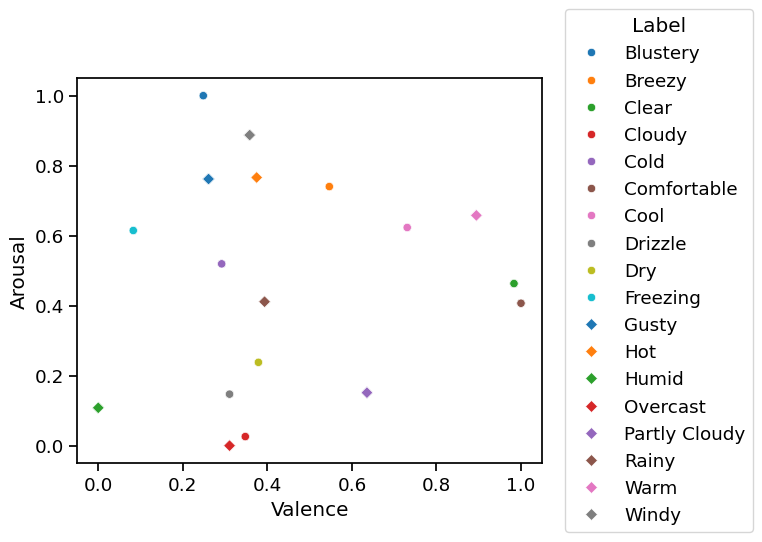

In [26]:
# Visualise the selected VA locations.
va_scatter(label_set_df)
# sns.scatterplot(label_set_df, x='Valence', y='Arousal', hue="weather_word", palette=palette)

In [27]:
x_train,x_test,y_train,y_test = train_test_split(weather_dataset_df,label_set_df,test_size=0.2,random_state=123)

## Create the ML Model and train by the annotated data

In [28]:
weather_dataset_df.shape

(4971, 8)

In [29]:
num_weather_features = weather_dataset_df.shape[1]

In [30]:
weather_emotion_fnn.create_model(units, num_weather_features, init_dropout_rate, dropout_rate)
weather_emotion_fnn.model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MeanSquaredError())

In [31]:
weather_emotion_fnn.model.fit(x_train, y_train.drop(columns=["weather_word"]), epochs=300, batch_size=32)

Epoch 1/300
125/125 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 2/300
125/125 [==============================] - 0s 544us/step - loss: 0.0739
Epoch 3/300
125/125 [==============================] - 0s 547us/step - loss: 0.0719
Epoch 4/300
125/125 [==============================] - 0s 532us/step - loss: 0.0713
Epoch 5/300
125/125 [==============================] - 0s 525us/step - loss: 0.0712
Epoch 6/300
125/125 [==============================] - 0s 521us/step - loss: 0.0706
Epoch 7/300
125/125 [==============================] - 0s 518us/step - loss: 0.0705
Epoch 8/300
125/125 [==============================] - 0s 547us/step - loss: 0.0704
Epoch 9/300
125/125 [==============================] - 0s 553us/step - loss: 0.0698
Epoch 10/300
125/125 [==============================] - 0s 576us/step - loss: 0.0697
Epoch 11/300
125/125 [==============================] - 0s 538us/step - loss: 0.0701
Epoch 12/300
125/125 [==============================] - 0s 540us/step - loss

In [32]:
weather_emotion_fnn.model.evaluate(x_test, y_test.drop(columns=["weather_word"]), verbose=0)

0.06628500670194626

## Prediction

In [33]:
y_train_pred = weather_emotion_fnn.model.predict(x_train)
y_test_pred = weather_emotion_fnn.model.predict(x_test)

32/32 [==============================] - 0s 273us/step


In [34]:
y_train_pred

array([[0.62782216, 0.5996233 ],
       [0.21708457, 0.32230106],
       [0.5745093 , 0.5597064 ],
       ...,
       [0.539759  , 0.4956441 ],
       [0.281873  , 0.37794957],
       [0.361543  , 0.761205  ]], dtype=float32)

In [35]:
columns = [f"col_{i}" for i in range(12)]
va_columns = ['Valence', 'Arousal']
# y_train_df = pd.DataFrame(y_train, columns=va_columns, index=x_train.index)
# y_test_df = pd.DataFrame(y_test, columns=va_columns, index=x_test.index)
y_train_pred_df = pd.DataFrame(y_train_pred, columns=va_columns, index=y_train.index)
y_train_pred_df = y_train_pred_df.join(y_train["weather_word"])
y_test_pred_df = pd.DataFrame(y_test_pred, columns=va_columns, index=y_test.index)
y_test_pred_df = y_test_pred_df.join(y_test["weather_word"])


In [36]:
y_train

,Valence,Arousal,weather_word
3077,0.358178,0.887446,Windy
4919,0.310559,0.000000,Overcast
3637,0.260870,0.761905,Gusty
4621,0.347826,0.025974,Cloudy
2243,0.393375,0.411255,Rainy
...,...,...,...
1593,0.082816,0.614719,Freezing
4060,0.983437,0.463203,Clear
1346,0.291925,0.519481,Cold
3454,0.260870,0.761905,Gusty


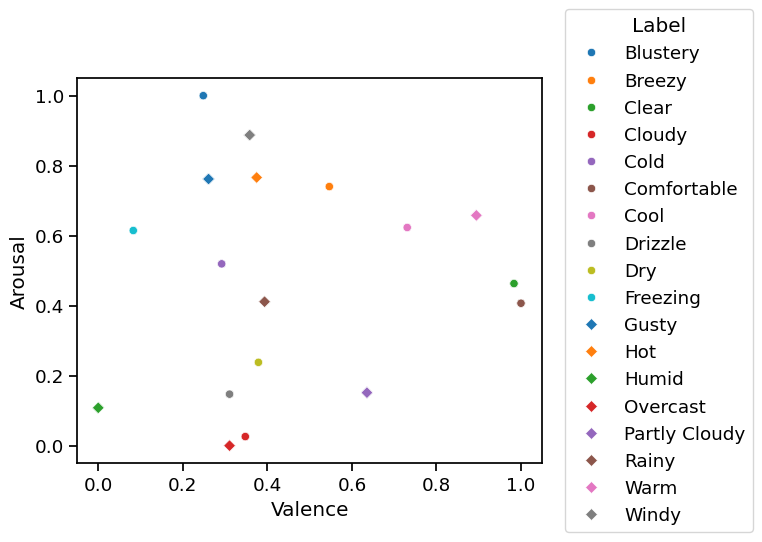

In [37]:
# sns.scatterplot(y_train, x='Valence', y='Arousal', hue='weather_word', palette=palette)
va_scatter(y_train)

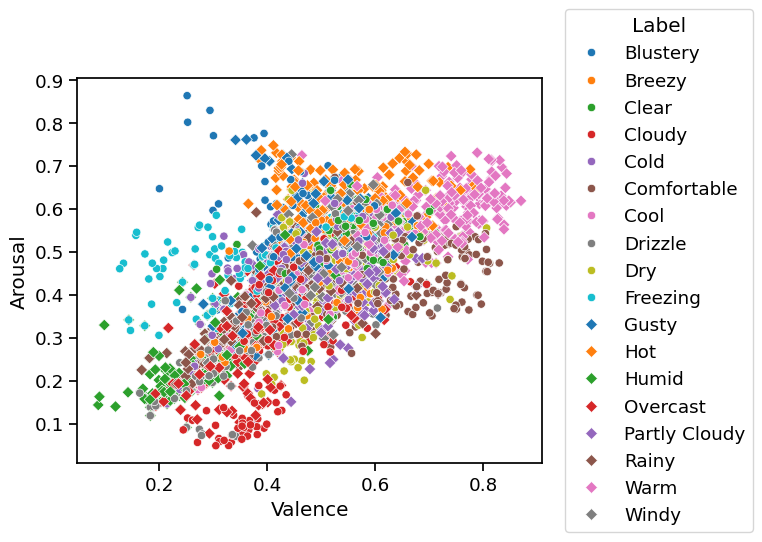

In [38]:
# sns.scatterplot(y_train_pred_df, x='Valence', y='Arousal', hue='weather_word', palette=palette)
va_scatter(y_train_pred_df)

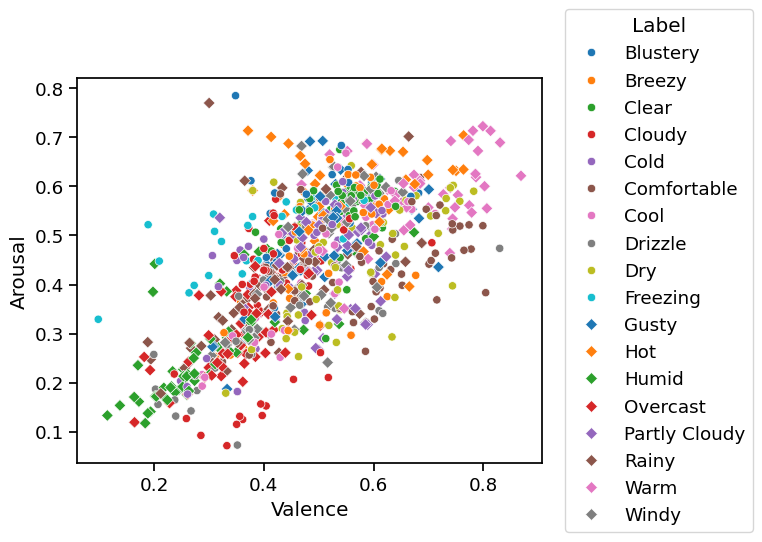

In [39]:
# sns.scatterplot(y_test_pred_df, x='Valence', y='Arousal', hue='weather_word', palette=palette)
va_scatter(y_test_pred_df)

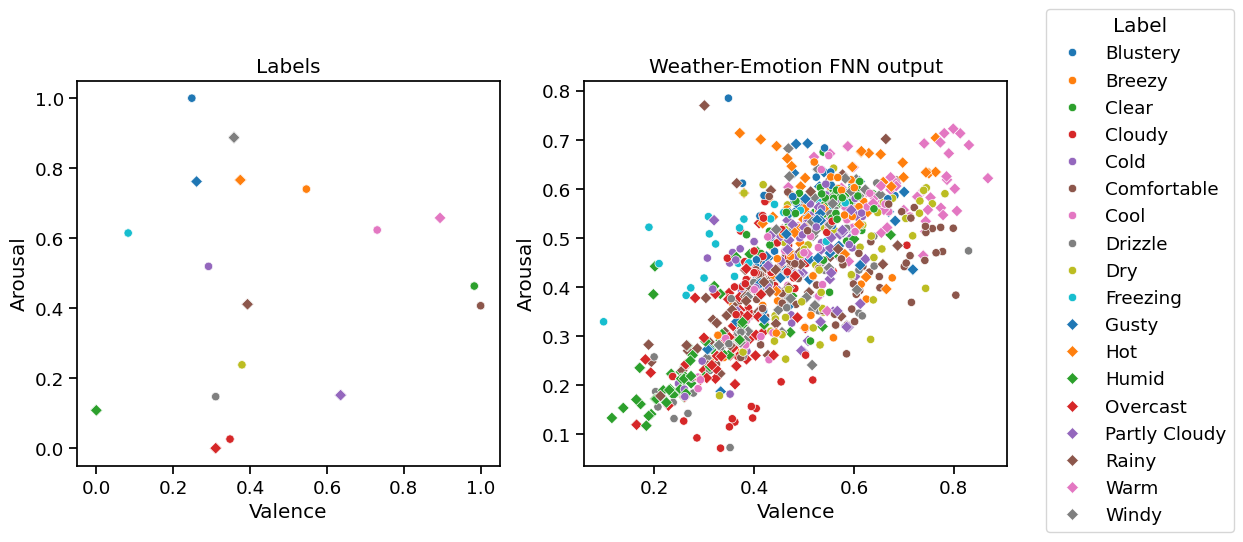

In [40]:
va_scatter2(label_set_df, y_test_pred_df, ['Labels', 'Weather-Emotion FNN output'])

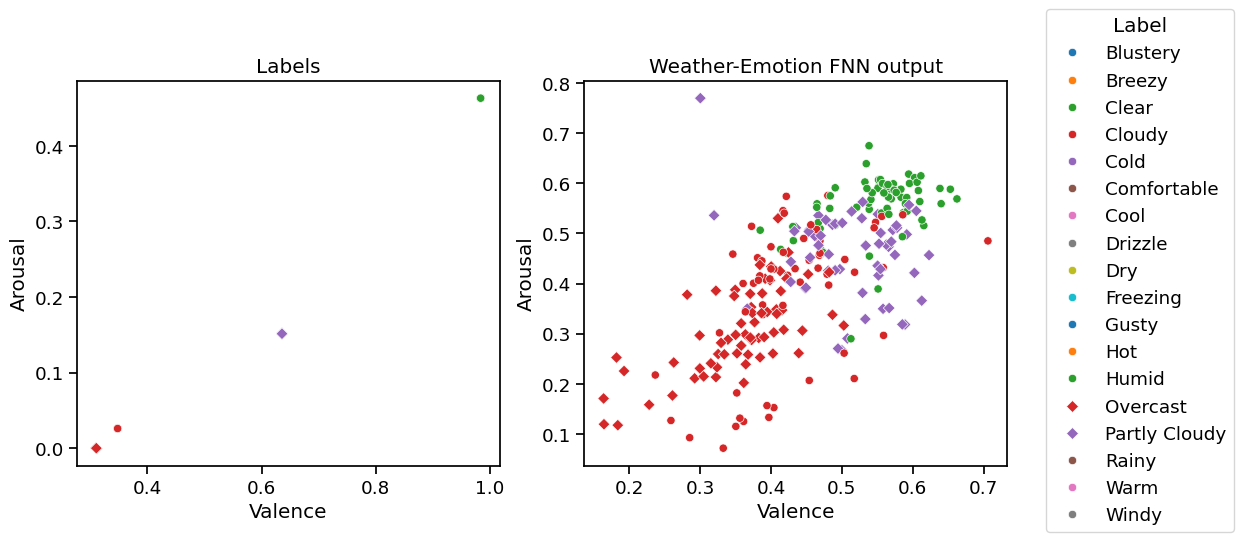

In [41]:
# Display the cloud related words only.

cloud_words = ['Clear', 'Partly Cloudy', 'Cloudy', 'Overcast']
label_set_df_clouds = label_set_df[label_set_df['weather_word'].isin(cloud_words)]
y_test_pred_df_clouds = y_test_pred_df[y_test_pred_df['weather_word'].isin(cloud_words)]
va_scatter2(label_set_df_clouds, y_test_pred_df_clouds, ['Labels', 'Weather-Emotion FNN output'])

## Calculate the R2 score

In [42]:
# Calculate R2 score on the training data.
r2_score(y_train.drop(columns=["weather_word"]), y_train_pred_df.drop(columns=["weather_word"]))

0.3048306586938829

In [43]:
# Calculate R2 score on the test data.
r2_score(y_test.drop(columns=["weather_word"]), y_test_pred_df.drop(columns=["weather_word"]))

0.20491996972337517

In [44]:
y_train

,Valence,Arousal,weather_word
3077,0.358178,0.887446,Windy
4919,0.310559,0.000000,Overcast
3637,0.260870,0.761905,Gusty
4621,0.347826,0.025974,Cloudy
2243,0.393375,0.411255,Rainy
...,...,...,...
1593,0.082816,0.614719,Freezing
4060,0.983437,0.463203,Clear
1346,0.291925,0.519481,Cold
3454,0.260870,0.761905,Gusty


In [45]:
y_train_pred

array([[0.62782216, 0.5996233 ],
       [0.21708457, 0.32230106],
       [0.5745093 , 0.5597064 ],
       ...,
       [0.539759  , 0.4956441 ],
       [0.281873  , 0.37794957],
       [0.361543  , 0.761205  ]], dtype=float32)

## Save the trained model

In [46]:
weather_emotion_fnn.save_model()

INFO:tensorflow:Assets written to: /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/saved_models/WeatherEmotionFNN.tf/assets


INFO:tensorflow:Assets written to: /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/saved_models/WeatherEmotionFNN.tf/assets
